In [4]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

/home/jiin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

# of all Events, # of sids =  4203 15629


In [7]:
# # Profile Extraction Functions
# def profile_extraction2(speed_all):
#     # Day of Week => monday : 0, sunday : 6
#     speed_all['weekday'] = [s.weekday() for s in speed_all.index]
#     speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
#     profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
#     profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
#     speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
#     return speed_all, profile_mean, profile_std

## Cascading Incident All List

In [ ]:
data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]
len(filtered_ID)

In [ ]:
target_all = []
for eventID in tqdm(selected_ID):
    try:
        with open('../Duration Estimation Thesis/feature_extraction/target/{}'.format(eventID), 'rb') as f:
            out = pickle.load(f)
    except:
        continue
        
    if out != None:
        out = [eventID] + out
        target_all.append(out)

In [94]:
target_all = pd.DataFrame(target_all, columns=['eventID', 'speed_drop', 'congestion_score', 'cascading_event', 'congestion_start_idx', 'congestion_duration'])
target_all

,eventID,speed_drop,congestion_score,cascading_event,congestion_start_idx,congestion_duration
0,3664293,sid 1220006106 0.550845 1230000201 0.571...,sid 1220006106 0 1230000201 0 1230000301...,False,NaT,0.0
1,3664294,sid 1150009303 NaN 1150009500 0.419...,sid 1150009303 0 1150009500 0 1150010102...,False,NaT,0.0
2,3664295,sid 1230000401 0.000000 1230000402 0.164...,sid 1230000401 0 1230000402 0 1230039000...,False,NaT,0.0
3,3664311,sid 1180004201 0.114540 1180004202 0.120...,sid 1180004201 0 1180004202 0 1180005100...,False,NaT,0.0
4,3664313,sid 1010011401 0.714007 1010014003 0.688...,sid 1010011401 0 1010014003 0 1010014101...,False,NaT,0.0
...,...,...,...,...,...,...
3949,3803511,sid 1080003802 NaN 1080003803 ...,sid 1080003802 0 1080003803 0 1080005400...,False,NaT,0.0
3950,3803512,sid 1020056700 NaN 1210024802 0.630...,sid 1020056700 0 1210024802 1 1210026603...,False,NaT,0.0
3951,3803553,sid 1030000103 0.296786 1030000304 0.575...,sid 1030000103 1 1030000304 1 1030000500...,True,2021-02-28 17:00:00,75.0
3952,3803559,sid 1030001800 0.665656 1030001902 0.180...,sid 1030001800 1 1030001902 1 1030002400...,False,NaT,0.0


In [95]:
cascading_list = target_all[target_all.cascading_event == True]
cascading_list.head()

,eventID,speed_drop,congestion_score,cascading_event,congestion_start_idx,congestion_duration
137,3674056,sid 1080005201 0.681448 1080005202 0.624...,sid 1080005201 1 1080005202 1 1080005203...,True,2020-09-16 11:25:00,25.0
140,3674448,sid 1020000101 0.653002 1020000501 0.689...,sid 1020000101 1 1020000501 1 1020000701...,True,2020-09-16 13:20:00,60.0
144,3674530,sid 1060066700 0.259001 1070016301 ...,sid 1060066700 1 1070016301 1 1070016302...,True,2020-09-16 16:05:00,110.0
145,3674610,sid 1130004304 0.824639 1130006902 0.588...,sid 1130004304 1 1130006902 1 1130006903...,True,2020-09-16 16:15:00,45.0
148,3674755,sid 1060006201 0.188882 1060006601 0.000...,sid 1060006201 1 1060006601 1 1100008002...,True,2020-09-16 21:10:00,10.0


In [82]:
accident_info_all = []
for eventID in filtered_ID:
    ## ===== Load extracted data =====
    eventID = str(eventID)
    

    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']
    
    if eventID not in list(cascading_list.eventID):
        continue

    accident_info_all.append(accident_info[0]) 
    
    

In [97]:
accident_all = pd.DataFrame(accident_info_all)
accident_all['accident_sid'] = accident_all['sids'].apply(lambda s: s[0])
accident_all.head()

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
80,3674056,2020-09-16 10:53:16,2020-09-16 10:31:00,2020-09-16 11:01:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 도봉로 수유치과의원 에서 수유사거리 방향 3차로 고장 차량 주의운전,[1080005204],127.023848,37.632308,1080005204
68,3674448,2020-09-16 13:33:00,2020-09-16 13:31:00,2020-09-16 13:51:00,NaT,NaT,tbs 교통방송,ACCIDENT,강변북로 (일산 → 구리) 동작대교 조금 못 간 저점 2차로 승용차끼리 추돌사고로 정체,[1020000101],126.979425,37.516094,1020000101
73,3674530,2020-09-16 15:39:20,2020-09-16 15:29:00,2020-09-16 15:59:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 화랑로 과기원후문 에서 월곡시장 방향 3차로 고장 차량 주의운전,[1070046900],127.043284,37.603680,1070046900
77,3674610,2020-09-16 16:21:00,2020-09-16 16:13:00,2020-09-16 16:43:00,NaT,NaT,경기도 교통정보센터,ACCIDENT,"[사고] 강변북로 (구리방향) 난지IC → 성산대교 2차로 통제, 사고",[1130004304],126.890628,37.560333,1130004304
75,3674755,2020-09-16 20:21:19,2020-09-16 19:56:00,2020-09-16 20:26:00,NaT,NaT,경찰청(UTIC),ACCIDENT,[사고] 화랑로 화랑대사거리 에서 화랑대역 방향 4차로 교통사고,[1100009100],127.086716,37.621437,1100009100


In [ ]:
# accident_all.to_csv('data/accident_all.csv')

## Data Loading

In [8]:
## load accident_all
accident_all = pd.read_csv('data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [9]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [10]:
    target_sid = 1030001902 ## 1030001902    ## 1210005301
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

#         df_all_norm = df_all_norm.rolling(3).mean()

    # define anomaly label
    labels = []
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

/tmp/ipykernel_3111490/252553352.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


In [11]:
# from datasets.Myloader import profile_loader
# train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
# len(train_loader), len(val_loader), len(test_loader)

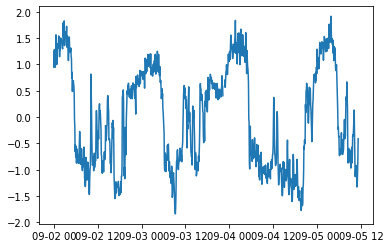

In [12]:
plt.plot(df_all_norm[:1000][accident_sid])

## Congestion Label 수정

In [13]:
plot=True

!!!
!!!
!!!
!!!
!!!
!!!


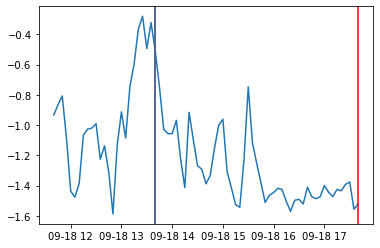

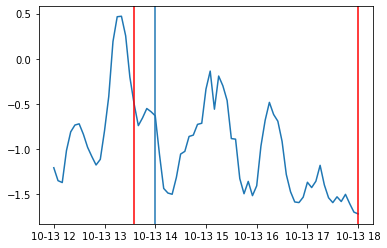

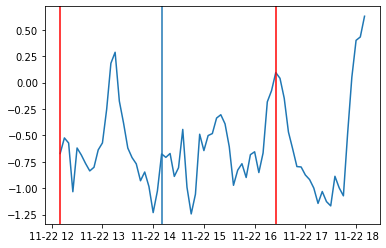

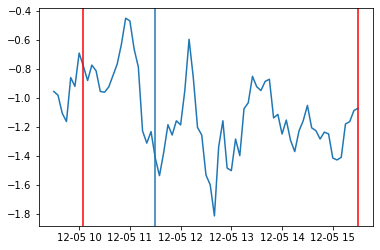

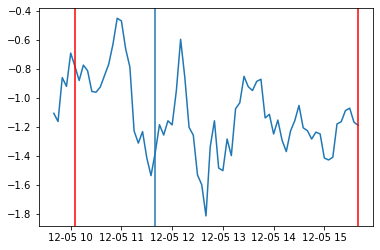

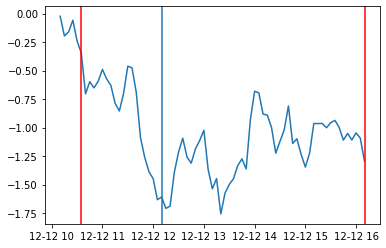

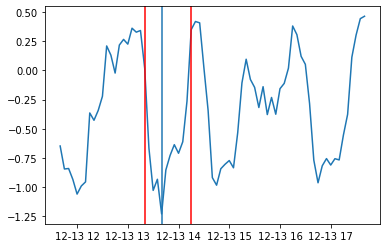

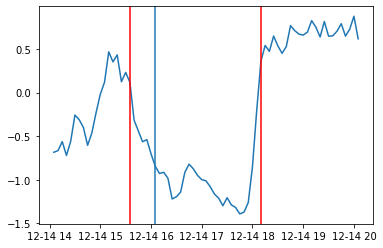

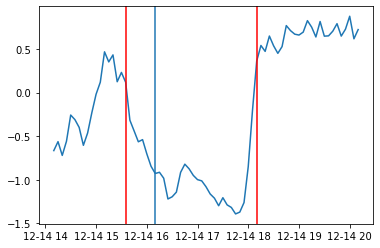

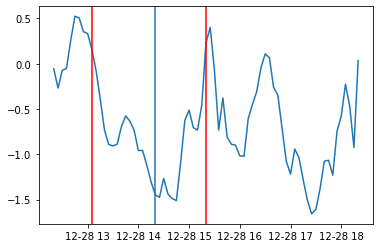

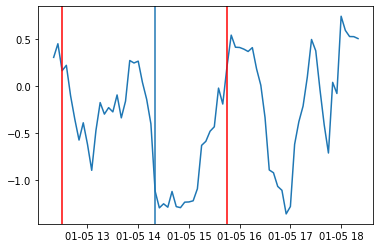

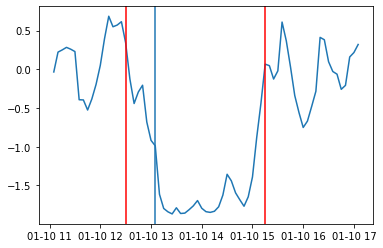

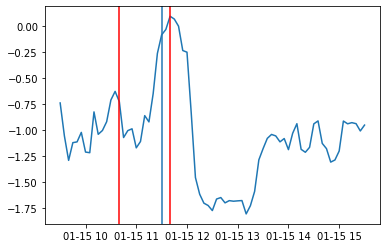

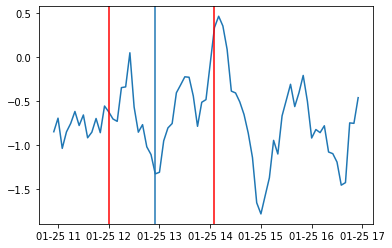

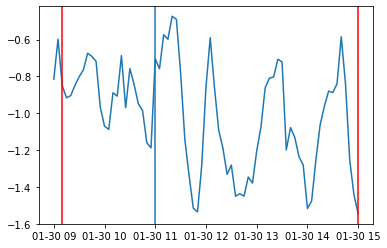

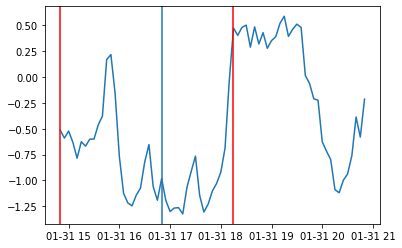

In [14]:
label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
cnt = 0

## Incident Data Plot
for ix, row in accident_case.iterrows():
    t = row['created']
    accident_sid = row['accident_sid']
#     if (t.month != 1) and (t.month != 12):
#         continue
    if (t.month == 2):
        continue

    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    accident_dt = accident_info[0]['created'].to_pydatetime()
    accident_dt = datetime.fromtimestamp(round(accident_dt.timestamp()/300)*300)
    accident_idx = np.where(df_all_norm.index == accident_dt)[0][0]
    df_pre = df_all_norm[accident_dt - timedelta(minutes=120):accident_dt]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    if len(congestion_start_list) == 0:
        congestion_start_time = accident_dt
    else:
        congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=60):accident_dt]
    zero_condition = pd.DataFrame(0, index=df_avg_pre_new.index, columns=df_avg_pre_new.columns)
    df_end_condition = (np.maximum(zero_condition.mean(), df_avg_pre_new.mean()) < df_all_norm)[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4)]
    if len(congestion_end_list) == 0:
        print("!!!")
        congestion_end_list = [accident_idx+12*4]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()

#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)
    if plot==True:
        plt.figure()
        plt.plot(df_all_norm[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid])
        plt.axvline(congestion_start_time, color='red')
        plt.axvline(congestion_end_time, color='red')
        plt.axvline(accident_dt)
        
    cnt += 1
    ## Label generation
    label_df[congestion_start_time:congestion_end_time] = 1

    

label    589
dtype: int64

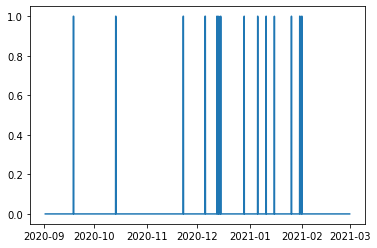

In [15]:
plt.plot(label_df)
label_df.sum()

## Speed Data Preprocessing

### Scaling

In [16]:
from sklearn.preprocessing import RobustScaler

In [17]:
## Scaling
sc = RobustScaler()
transform = sc.fit_transform(df_all_norm)
df_all_norm = pd.DataFrame(transform, index=df_all_norm.index, columns=df_all_norm.columns)

In [18]:
rolling_window = 3
df_all_norm = df_all_norm.rolling(rolling_window).mean()
df_all_norm = df_all_norm.iloc[rolling_window-1:]

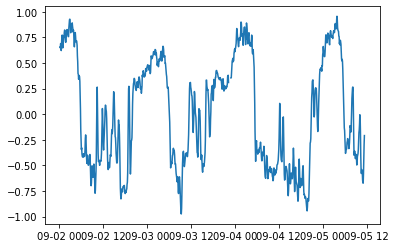

In [19]:
plt.plot(df_all_norm[:1000][accident_sid])

### NaN values 

In [20]:
train_df = df_all_norm[df_all_norm.index < datetime(2020, 12, 1)]
val_df = df_all_norm[(df_all_norm.index >= datetime(2020, 12, 1)) & (df_all_norm.index < datetime(2021, 1, 1))]
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]

In [21]:
train_df.shape, test_df.shape

((25918, 21), (8928, 21))

In [22]:
train_df = train_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
val_df = val_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
test_df = test_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)

In [23]:
train_df.shape, test_df.shape

((25918, 21), (8928, 21))

## Sensor Graph

In [24]:
len(H.nodes)

21

In [25]:
sid_list = list(map(int, train_df.columns))

In [26]:
H = nx.subgraph(H, sid_list)

### Save

In [28]:
dataset = '{}'.format(target_sid)

In [30]:
os.makedirs('data/{}'.format(dataset), exist_ok=True)

In [31]:
train_df.to_csv('data/{}/train_x.csv'.format(dataset))
val_df.to_csv('data/{}/val_x.csv'.format(dataset))
test_df.to_csv('data/{}/test_x.csv'.format(dataset))

In [32]:
label_df = label_df.iloc[rolling_window-1:]
label_df.to_csv('data/{}/labels.csv'.format(dataset))

In [33]:
train_label = label_df[label_df.index < datetime(2020, 12, 1)]
val_label = label_df[(label_df.index >= datetime(2020, 12, 1)) & (label_df.index < datetime(2021, 1, 1))]
test_label = label_df[(label_df.index >= datetime(2021, 1, 1)) & (label_df.index < datetime(2021, 2, 1))]

In [34]:
train_label.to_csv('data/{}/train_y.csv'.format(dataset))
val_label.to_csv('data/{}/val_y.csv'.format(dataset))
test_label.to_csv('data/{}/test_y.csv'.format(dataset))

In [ ]:
## network graph
nx.write_gpickle(H.copy(), "data/{}/sensor_graph.gpickle".format(dataset))